In [1]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import random
from pylab import mpl, plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop

# Yahoo finance
import yfinance as yf

# Datetime
import datetime as dt
from datetime import datetime
from datetime import timedelta

In [2]:
start=pd.to_datetime('1990-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')

In [3]:
lags = 5
optimizer = Adam(learning_rate=0.0001)
cutoff = '2020-12-31'

In [4]:
#model = MLPClassifier(hidden_layer_sizes=[32],max_iter=1000, random_state=100)

In [5]:
df = yf.download("JPY=x", start=start,end=today_date)

[*********************100%%**********************]  1 of 1 completed


In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0
...,...,...,...,...,...,...
2024-08-13,146.981995,147.929993,146.910995,146.981995,146.981995,0
2024-08-14,146.970993,147.552002,146.080994,146.970993,146.970993,0
2024-08-15,147.253006,149.263000,147.063004,147.253006,147.253006,0


In [7]:
df.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
df['direction'] = np.where(df['returns'] > 0, 1, 0)
df['momentum'] = df['returns'].rolling(5).mean().shift(1)
df['volatility'] = df['returns'].rolling(20).std().shift(1)
df['distance'] = (df['Close'] - df['Close'].rolling(50).mean()).shift(1)

print(df)

                 Close   returns  direction  momentum  volatility  distance
Date                                                                       
1996-10-30  114.180000       NaN          0       NaN         NaN       NaN
1996-11-01  113.500000 -0.005973          0       NaN         NaN       NaN
1996-11-04  113.879997  0.003342          1       NaN         NaN       NaN
1996-11-05  114.250000  0.003244          1       NaN         NaN       NaN
1996-11-06  113.949997 -0.002629          0       NaN         NaN       NaN
...                ...       ...        ...       ...         ...       ...
2024-08-13  146.981995 -0.000408          0  0.001993    0.009334 -9.067473
2024-08-14  146.970993 -0.000075          0  0.001629    0.009345 -8.923525
2024-08-15  147.253006  0.001917          1  0.003070    0.009311 -8.752427
2024-08-16  149.222000  0.013283          1  0.001539    0.008844 -8.312994
2024-08-17  147.578995 -0.011072          0  0.002092    0.009165 -6.209860

[7210 rows 

In [8]:
cols = []
for lag in range(1, lags + 1):
              col = f'lag_{lag}'
              df[col] = df['returns'].shift(lag)
              cols.append(col)
df.dropna(inplace=True)

In [9]:
df.round(4).head()

,Close,returns,direction,momentum,volatility,distance,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,,,,
1997-01-15,116.77,-0.0015,0,0.0030,0.0037,3.1112,0.0039,0.0032,-0.0017,0.0040,0.0055
1997-01-16,116.54,-0.0020,0,0.0016,0.0037,2.8894,-0.0015,0.0039,0.0032,-0.0017,0.0040
1997-01-17,117.32,0.0067,1,0.0004,0.0037,2.5986,-0.0020,-0.0015,0.0039,0.0032,-0.0017
1997-01-20,117.91,0.0050,1,0.0021,0.0039,3.3098,0.0067,-0.0020,-0.0015,0.0039,0.0032
1997-01-21,117.88,-0.0003,0,0.0024,0.0040,3.8266,0.0050,0.0067,-0.0020,-0.0015,0.0039


In [10]:
def set_seeds(seed=100): 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)


In [11]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',input_shape=(len(cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])


/Users/benny/Desktop/Projects/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
training_data = df[df.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

In [13]:
test_data = df[df.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [14]:
%%time
model.fit(training_data[cols],
        training_data['direction'],
        epochs=50, verbose=False,
        validation_split=0.2, shuffle=False)

CPU times: user 6.17 s, sys: 772 ms, total: 6.94 s
Wall time: 5.56 s


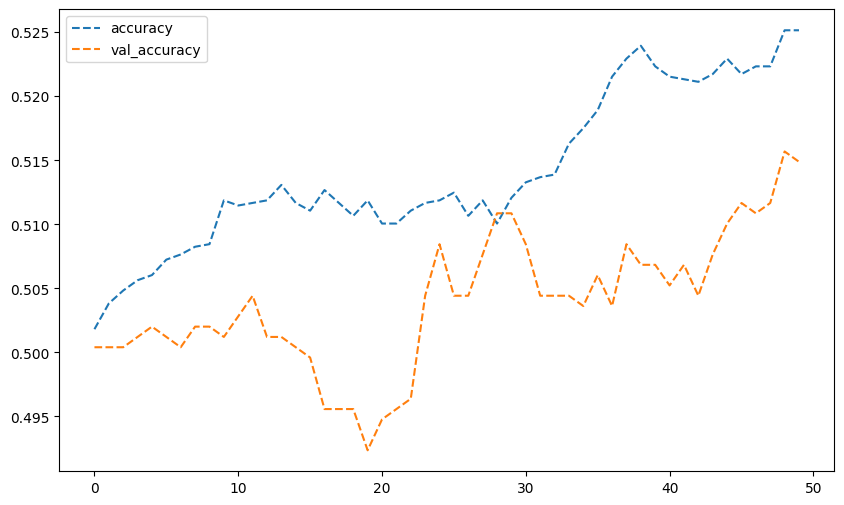

In [15]:
res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [16]:
model.evaluate(training_data_[cols], training_data['direction'])

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.5175 - loss: 1.4258


[1.281395435333252, 0.5279253125190735]

In [17]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] * training_data['returns'])

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


In [18]:
training_data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.885574
strategy    3.878852
dtype: float64

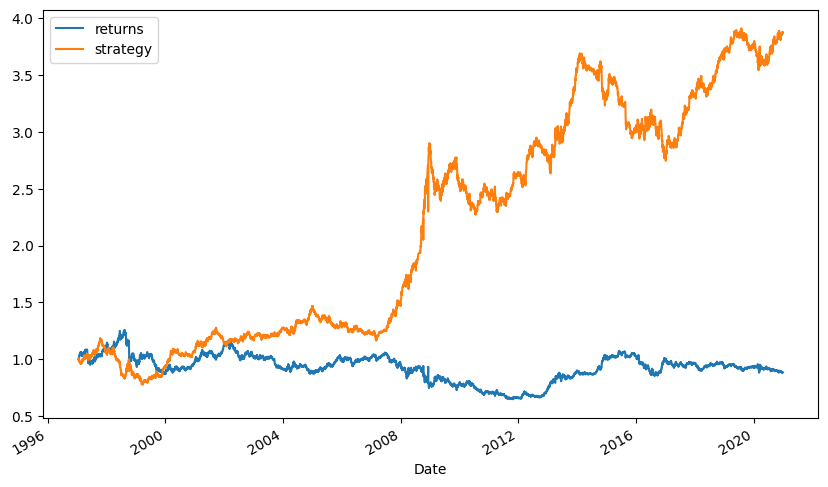

In [19]:
training_data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [20]:
model.evaluate(test_data_[cols], test_data['direction'])

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.4865 - loss: 1.1951


[1.3194891214370728, 0.47624075412750244]

In [21]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['strategy'] = (test_data['prediction'] *test_data['returns'])

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


In [22]:
test_data[['returns', 'strategy']].sum().apply(np.exp)

returns     1.425072
strategy    0.697601
dtype: float64

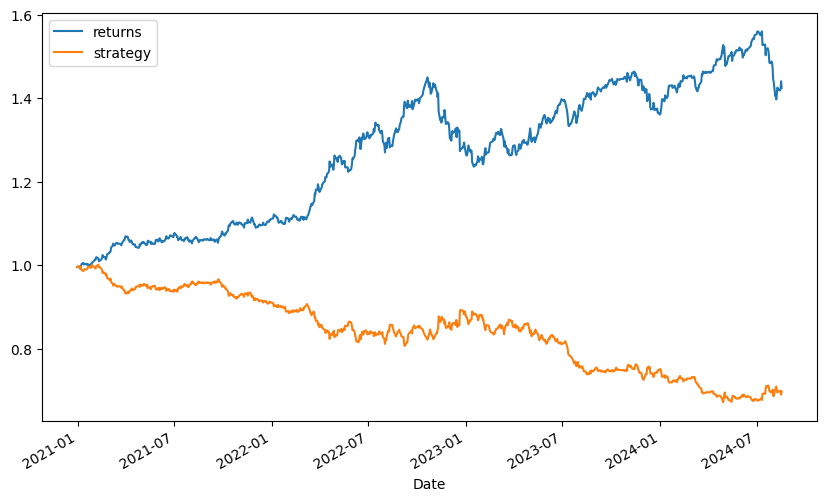

In [23]:
test_data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));